In [1]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from pylab import rcParams

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
aapl=pd.read_csv('AAPL.csv',parse_dates=['Date'])
msft=pd.read_csv('MSFT.csv',parse_dates=['Date'])

In [4]:
aapl_open=aapl[['Date', 'Open']]
msft_open=msft[['Date', 'Open']]
aapl_open=aapl_open.set_index('Date')
msft_open=msft_open.set_index('Date')

In [5]:
aapl_open.head()

,Open
Date,
2009-09-21,6.581786
2009-09-22,6.613929
2009-09-23,6.621428
2009-09-24,6.685714
2009-09-25,6.500357


In [6]:
msft_open.head()

,Open
Date,
2009-09-21,25.110001
2009-09-22,25.400000
2009-09-23,25.920000
2009-09-24,25.920000
2009-09-25,25.690001


In [7]:
def test_stationarity(timeseries):
    
#Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std() 

#Plot rolling statistics:
    plt.figure(figsize=(10,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
#Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Text(0.5, 1.0, 'AAPL Autocorrelation')

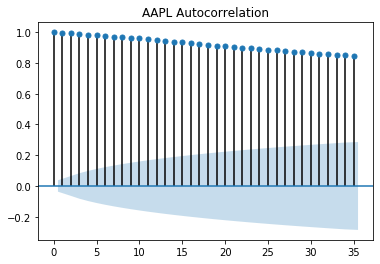

In [8]:
plot_acf(aapl_open)
plt.title('AAPL Autocorrelation')

Text(0.5, 1.0, 'MSFT Autocorrelation')

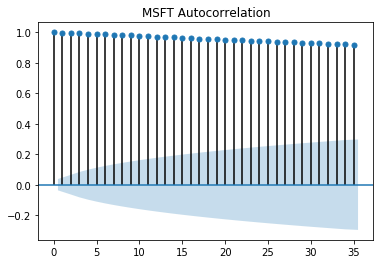

In [9]:
plot_acf(msft_open)
plt.title('MSFT Autocorrelation')

# AAPL Stock

Stationarity test and data transformation

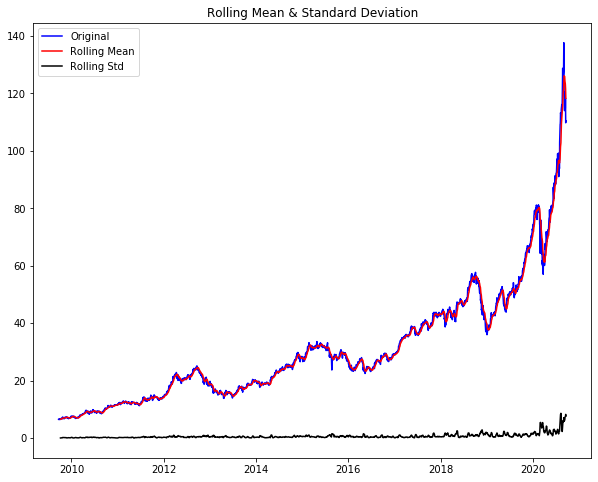

Results of Dickey-Fuller Test:
Test Statistic                    1.973091
p-value                           0.998637
#Lags Used                       27.000000
Number of Observations Used    2741.000000
Critical Value (1%)              -3.432738
Critical Value (5%)              -2.862595
Critical Value (10%)             -2.567332
dtype: float64


In [10]:
test_stationarity(aapl_open)

In [11]:
aapl_open_dif=aapl_open.diff(periods=1)
aapl_open_dif=aapl_open_dif[1:]

In [12]:
aapl_open_dif.head()

,Open
Date,
2009-09-22,0.032143
2009-09-23,0.007499
2009-09-24,0.064286
2009-09-25,-0.185357
2009-09-28,0.066429


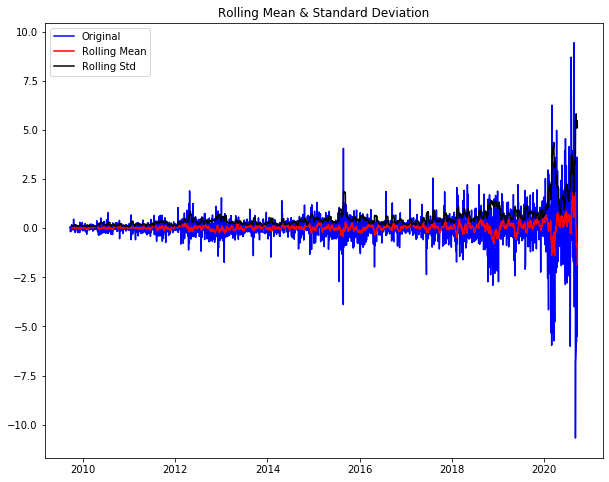

Results of Dickey-Fuller Test:
Test Statistic                -9.990012e+00
p-value                        2.007736e-17
#Lags Used                     2.600000e+01
Number of Observations Used    2.741000e+03
Critical Value (1%)           -3.432738e+00
Critical Value (5%)           -2.862595e+00
Critical Value (10%)          -2.567332e+00
dtype: float64


In [13]:
test_stationarity(aapl_open_dif)

Text(0.5, 1.0, 'AAPL Difference Autocorrelation')

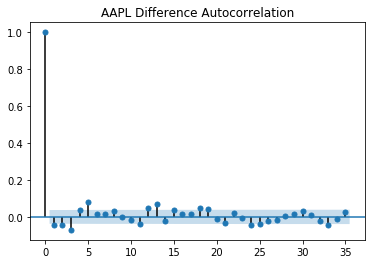

In [14]:
plot_acf(aapl_open_dif)
plt.title('AAPL Difference Autocorrelation')

In [15]:
train_ar_full=np.array(aapl_open[aapl_open.index<'2020-01-01'].Open)
test_ar_full=aapl_open[aapl_open.index>'2019-12-31'].Open

In [16]:
train_ar_full.size

2588

In [17]:
test_ar_full.size

181

In [18]:
aapl_open.size

2769

## AR model

In [19]:
model_ar_full=AR(train_ar_full)
model_ar_full_fit=model_ar_full.fit()
#model_ar_full_fit.predict(start=2588,end=2768).size
predictions_ar_full=pd.Series(model_ar_full_fit.predict(start=2588,end=2768),index=test_ar_full.index)

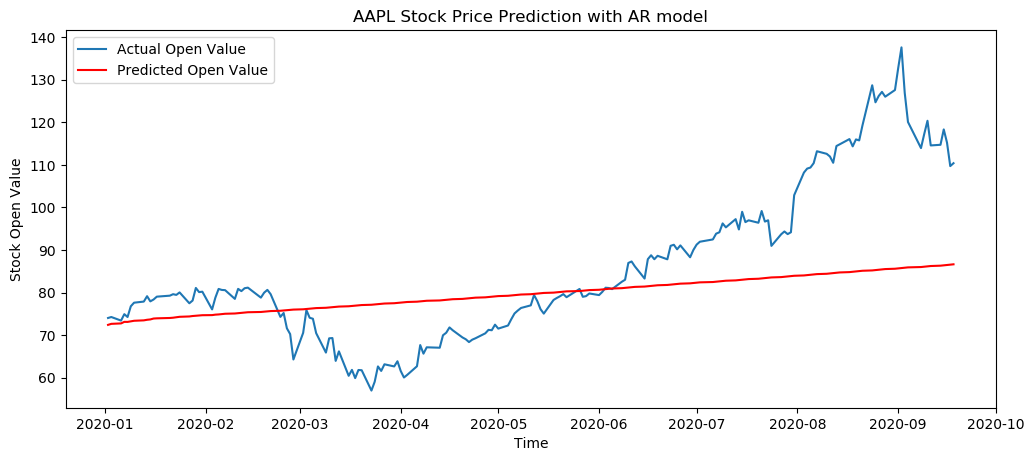

In [131]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_ar_full, label='Actual Open Value')
plt.plot(predictions_ar_full, color='red', label='Predicted Open Value')
plt.title('AAPL Stock Price Prediction with AR model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')
plt.legend(loc='best')

## Arima model

Firstly, with full data

In [21]:
train, test = aapl_open[aapl_open.index <'2020-01-01'],aapl_open[aapl_open.index >'2020-01-01']

In [24]:
model_ARIMA_full=auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=10, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=False
                      )
print(model_ARIMA_full.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3618.265, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3606.385, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3607.069, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3605.814, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3606.939, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3609.578, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3606.902, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3608.854, Time=2.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3601.974, Time=3.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3608.660, Time=1.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3610.436, Time=3.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3594.023, Time=3.68 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3607.714, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3608.376, Time=2.87 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3602.503, Time=1.48 sec
Total fit 

Text(0, 0.5, 'Stock Open Value')

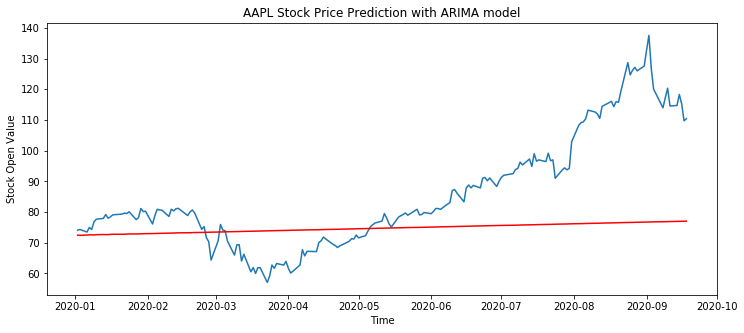

In [25]:
model_arima_full=ARIMA(train, order=(3,1,2))
model_arima_full_fit=model_arima_full.fit()
#predictions_arima_full=model_arima_full_fit.forecast(steps=181)[0]
predictions_arima_full=pd.Series(model_arima_full_fit.forecast(steps=181)[0], index=test.index)
plt.figure(figsize=(12,5))
plt.plot(test)
plt.plot(predictions_arima_full, color='red')
plt.title('AAPL Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

In [26]:
import itertools
p=d=q=range(0,10)
pdq=list(itertools.product(p,d,q))

In [27]:
for param in pdq:
    try:
        model_arima=ARIMA(train, order=param)
        model_arima_fit=model_arima.fit()
        predictions_arima=model_arima_fit.forecast(steps=181)[0]
        mse=mean_squared_error(test, predictions_arima)
        print(param,model_arima_fit.aic,mse)
    except:
        continue

(0, 0, 0) 21092.993892757644 3785.0389622878424
(0, 0, 1) 17653.249409625892 3775.156170384437
(0, 0, 2) 14716.534662277969 3765.5044936753143
(0, 0, 4) 10942.297820353535 3749.7626041950334
(0, 0, 5) 9755.695745032235 3745.2689603011213
(0, 0, 6) 8838.442331283057 3737.0059278930707
(0, 0, 8) 7533.387890970528 3722.056560905133
(0, 0, 9) 7157.307708312646 3716.6446340878992
(0, 1, 0) 3618.2645487404598 418.82970724772855
(0, 1, 1) 3606.3850937424904 418.9439970987655
(0, 1, 2) 3607.0691924972275 419.04459053984573
(0, 1, 3) 3608.1468014806296 419.58017872268147
(0, 1, 4) 3608.4088037554593 420.41466158360265
(0, 1, 5) 3599.7429983343604 417.2670788555809
(0, 1, 6) 3588.2231255446322 414.9144521826073
(0, 1, 7) 3589.5201520364226 415.5959185465313
(0, 1, 8) 3591.065774847817 415.0684262037584
(0, 1, 9) 3592.0670566326285 415.8572770549838
(0, 2, 0) 5596.502359036742 196.7396268482543
(0, 2, 1) 3624.648909941615 324.943948683494
(0, 2, 2) 3612.8003076372165 298.3599809983963
(0, 2, 3) 3

(9, 2, 7) 3587.5667439972804 275.18227764600067
(9, 2, 8) 3582.650290830117 309.0282348248392
(9, 2, 9) 3593.463391394843 323.7086011805741


Text(0, 0.5, 'Stock Open Value')

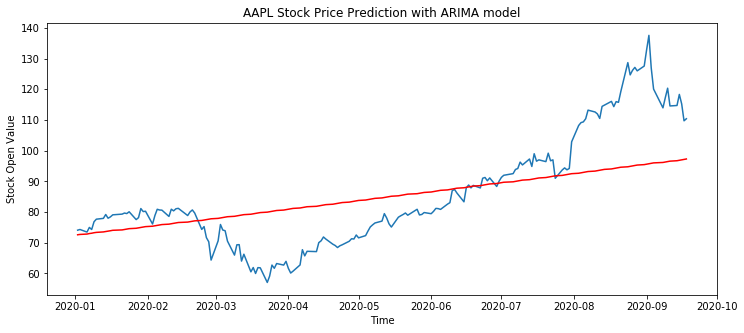

In [28]:
model_arima_full=ARIMA(train, order=(5,2,2))
model_arima_full_fit=model_arima_full.fit()
#predictions_arima_full=model_arima_full_fit.forecast(steps=181)[0]
predictions_arima_full=pd.Series(model_arima_full_fit.forecast(steps=181)[0], index=test.index)
plt.figure(figsize=(12,5))
plt.plot(test)
plt.plot(predictions_arima_full, color='red')
plt.title('AAPL Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

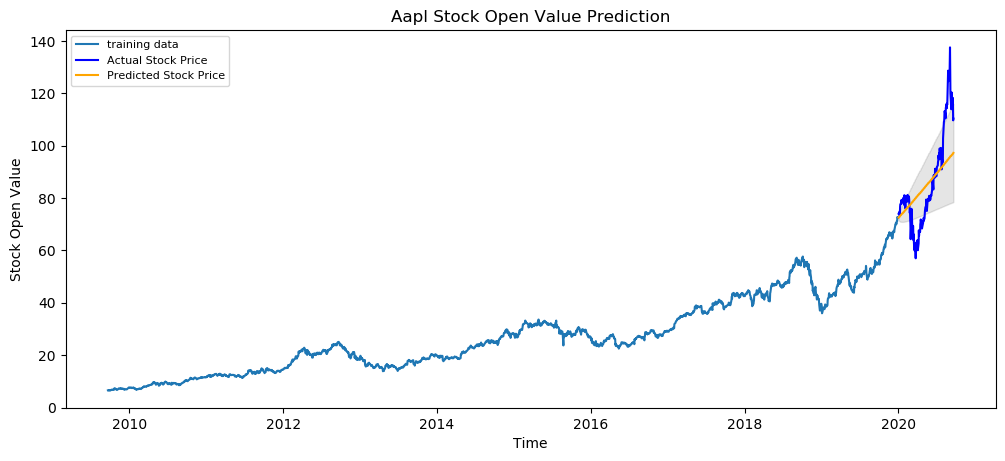

In [40]:
fc, se, conf = model_arima_full_fit.forecast(181, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Aapl Stock Open Value Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

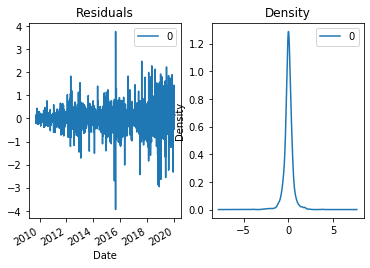

In [129]:
residuals_full = pd.DataFrame(model_arima_full_fit.resid)
fig, ax = plt.subplots(1,2)
residuals_full.plot(title="Residuals", ax=ax[0])
residuals_full.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Only 2020 data

In [41]:
aapl_open_2=aapl_open[aapl_open.index>='2020-07-01']

In [44]:
aapl_open_2.head()

,Open
Date,
2020-07-01,91.279999
2020-07-02,91.962502
2020-07-06,92.500000
2020-07-07,93.852501
2020-07-08,94.180000


In [42]:
aapl_open_2_dif=aapl_open_2.diff(periods=1)
aapl_open_2_dif=aapl_open_2_dif[1:]

In [48]:
aapl_open_2_dif.head()

,Open
Date,
2020-07-02,0.682503
2020-07-06,0.537498
2020-07-07,1.352501
2020-07-08,0.327499
2020-07-09,2.082497


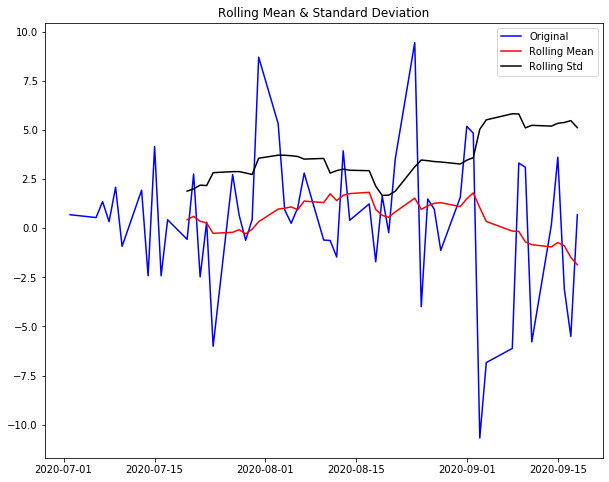

Results of Dickey-Fuller Test:
Test Statistic                -6.755884e+00
p-value                        2.872652e-09
#Lags Used                     0.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [43]:
test_stationarity(aapl_open_2_dif)

In [84]:
train_ar=np.array(aapl_open_2[aapl_open_2.index<'2020-09-01'].Open)
test_ar=aapl_open_2[aapl_open_2.index>'2020-08-31']

In [85]:
model_ar=AR(train_ar)
model_ar_fit=model_ar.fit()

In [88]:
predictions_ar=pd.Series(model_ar_fit.predict(start=43,end=55),index=test_ar.index)

Text(0, 0.5, 'Stock Open Value')

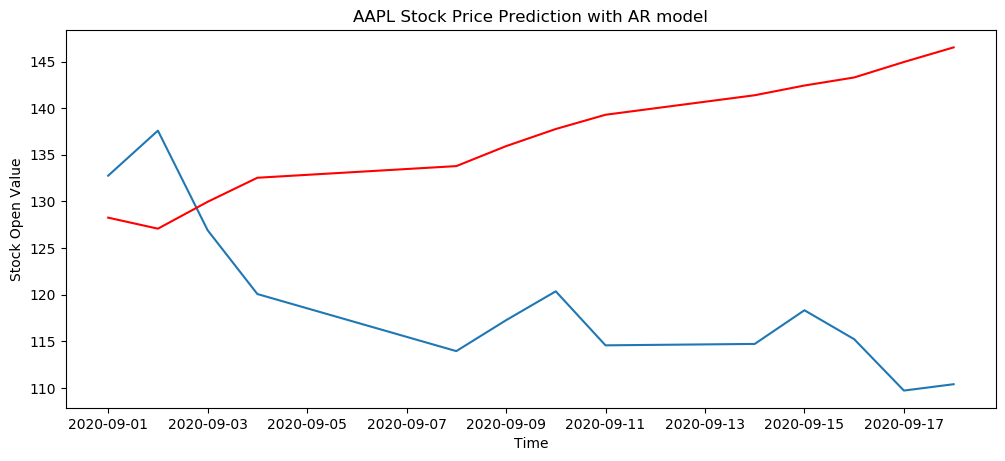

In [89]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_ar)
plt.plot(predictions_ar, color='red')
plt.title('AAPL Stock Price Prediction with AR model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

In [90]:
train_arima=aapl_open_2[aapl_open_2.index<'2020-09-01'].Open
test_arima=aapl_open_2[aapl_open_2.index>='2020-09-01'].Open

In [91]:
model_ARIMA=auto_arima(train_ar, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=10, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=False
                      )
print(model_ARIMA.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=209.994, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=211.182, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=213.154, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=214.630, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=216.465, Time=0.04 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=217.621, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=211.131, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=212.244, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=214.238, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=215.795, Time=0.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=217.740, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=213.075, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=214.239, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=214.365, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=216.795, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] i

In [92]:
model_arima=ARIMA(train_arima, order=(0,1,0))

In [93]:
model_arima_fit=model_arima.fit()

In [96]:
predictions_arima=pd.Series(model_arima_fit.forecast(steps=13)[0], index=test_arima.index)
predictions_arima

Date
2020-09-01    128.444288
2020-09-02    129.308574
2020-09-03    130.172859
2020-09-04    131.037145
2020-09-08    131.901431
2020-09-09    132.765717
2020-09-10    133.630003
2020-09-11    134.494288
2020-09-14    135.358574
2020-09-15    136.222860
2020-09-16    137.087146
2020-09-17    137.951431
2020-09-18    138.815717
dtype: float64

Text(0, 0.5, 'Stock Open Value')

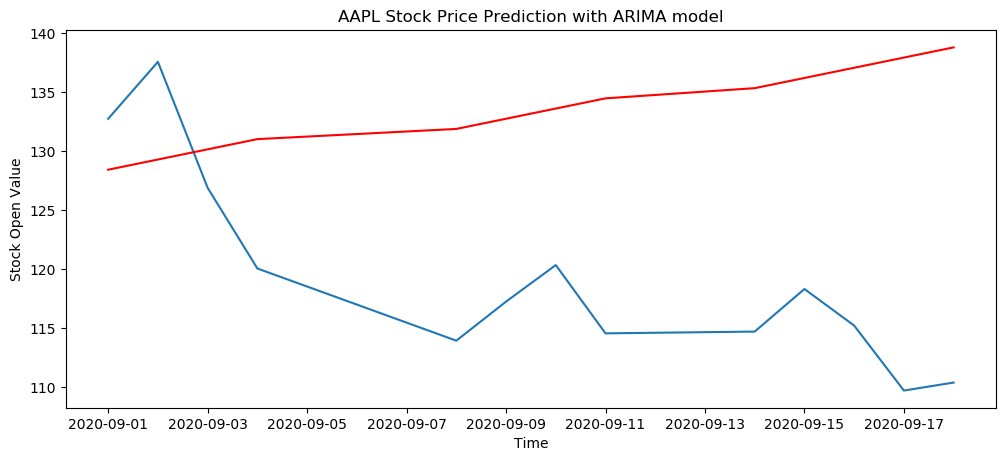

In [97]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_arima)
plt.plot(predictions_arima, color='red')
plt.title('AAPL Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

In [98]:
for param in pdq:
    try:
        model_arima=ARIMA(train_ar, order=param)
        model_arima_fit=model_arima.fit()
        predictions_arima=model_arima_fit.forecast(steps=13)[0]
        mse=mean_squared_error(test_ar, predictions_arima)
        print(param,model_arima_fit.aic,mse)
    except:
        continue

(0, 0, 0) 339.09949540555033 245.0120610699212
(0, 0, 1) 301.48379155266116 212.24440033310563
(0, 0, 2) 274.6657772838689 159.37818515976963
(0, 0, 3) 258.0042984165104 174.64520079946203
(0, 0, 4) 255.014547337474 109.9062714751438
(0, 0, 5) 251.3954135977196 109.72226804012824
(0, 0, 6) 236.70539482496156 81.48571210324643
(0, 0, 7) 238.4233395067105 77.46232053999455
(0, 0, 8) 238.777988887995 76.61506478540224
(0, 1, 0) 209.99368229383074 321.7068797441874
(0, 1, 1) 211.18170508785602 319.8379103522964
(0, 1, 2) 213.15400332783318 318.5440848440734
(0, 1, 3) 214.62979178026785 322.21066714263884
(0, 1, 4) 216.4647786965645 318.3365131765219
(0, 1, 5) 217.62103271040428 333.0463235756997
(0, 1, 6) 218.37876768581418 233.9220421439956
(0, 1, 7) 216.15478322133956 253.4977763487076
(0, 1, 8) 214.45285119654642 242.54149055106862
(0, 1, 9) 216.36578615201267 243.7753605423049
(0, 2, 0) 239.98820186915424 590.106087341091
(0, 2, 1) 211.36198921284665 518.8645276586346
(0, 2, 2) 212.684

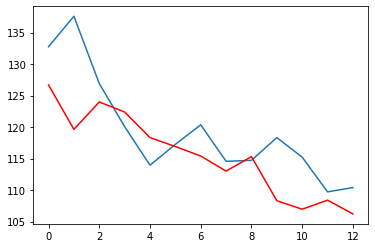

In [21]:
model_arima=ARIMA(train_ar, order=(9,0,0))
model_arima_fit=model_arima.fit()
predictions_arima=model_arima_fit.forecast(steps=13)[0]
plt.plot(test_ar)
plt.plot(predictions_arima, color='red')

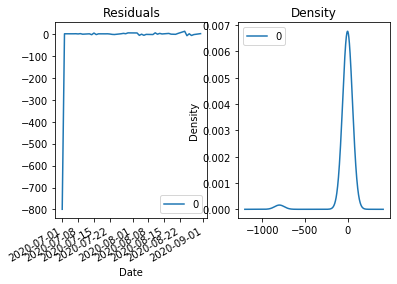

In [128]:
residuals = pd.DataFrame(model_arima_fit.resid)
#figsize=(10,6)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Text(0, 0.5, 'Stock Open Value')

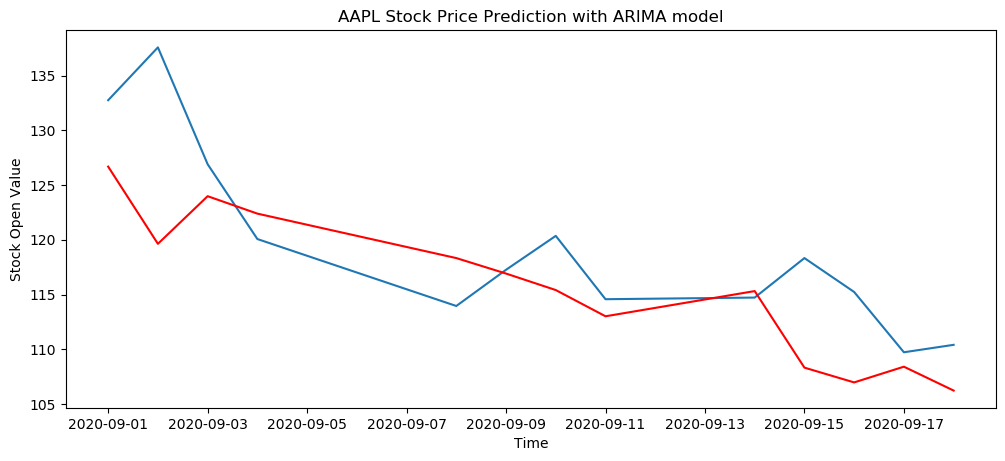

In [103]:
model_arima=ARIMA(train_arima, order=(9,0,0))
model_arima_fit=model_arima.fit()
predictions_arima=pd.Series(model_arima_fit.forecast(steps=13)[0], index=test_arima.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_arima)
plt.plot(predictions_arima, color='red')
plt.title('AAPL Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

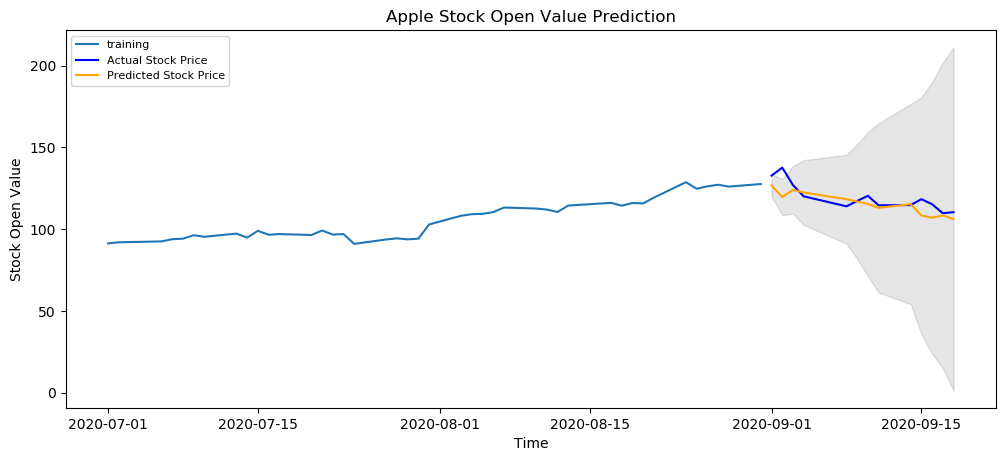

In [107]:
fc, se, conf = model_arima_fit.forecast(13, alpha=0.05)
fc_series = pd.Series(fc, index=test_arima.index)
lower_series = pd.Series(conf[:, 0], index=test_arima.index)
upper_series = pd.Series(conf[:, 1], index=test_arima.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_arima, label='training')
plt.plot(test_arima, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Open Value Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# MSFT Stock

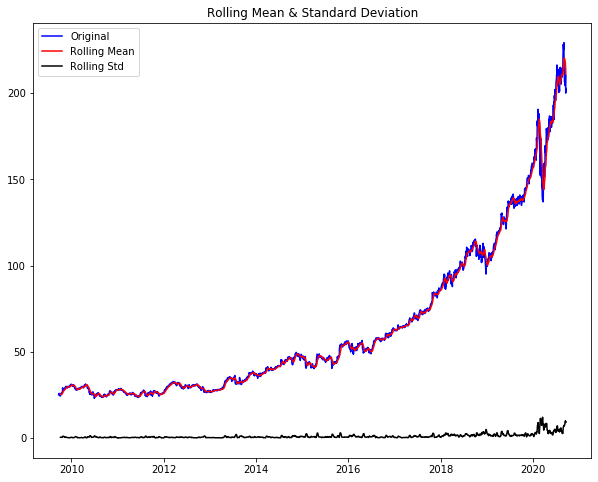

Results of Dickey-Fuller Test:
Test Statistic                    4.287284
p-value                           1.000000
#Lags Used                       28.000000
Number of Observations Used    2740.000000
Critical Value (1%)              -3.432739
Critical Value (5%)              -2.862595
Critical Value (10%)             -2.567332
dtype: float64


In [29]:
test_stationarity(msft_open)

In [30]:
msft_open_dif=msft_open.diff(periods=1)
msft_open_dif=msft_open_dif[1:]

In [31]:
msft_open_dif.head()

,Open
Date,
2009-09-22,0.289999
2009-09-23,0.520000
2009-09-24,0.000000
2009-09-25,-0.229999
2009-09-28,-0.090001


Text(0.5, 1.0, 'MSFT Difference Autocorrelation')

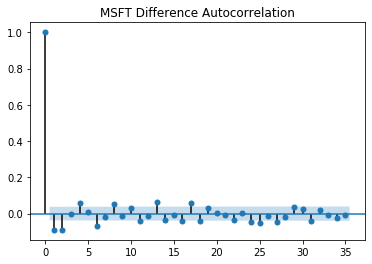

In [32]:
plot_acf(msft_open_dif)
plt.title('MSFT Difference Autocorrelation')

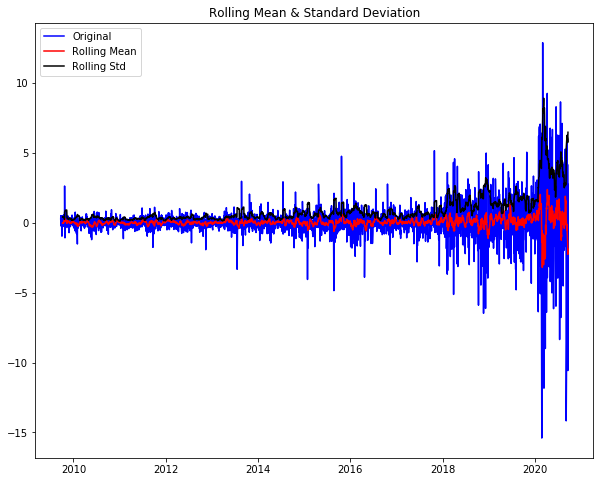

Results of Dickey-Fuller Test:
Test Statistic                -1.272080e+01
p-value                        9.837120e-24
#Lags Used                     2.700000e+01
Number of Observations Used    2.740000e+03
Critical Value (1%)           -3.432739e+00
Critical Value (5%)           -2.862595e+00
Critical Value (10%)          -2.567332e+00
dtype: float64


In [33]:
test_stationarity(msft_open_dif)

In [34]:
train_m, test_m = msft_open[aapl_open.index <'2020-01-01'],msft_open[aapl_open.index >'2019-12-31']

In [35]:
model_ARIMA_full_m=auto_arima(train_m, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=False
                      )
print(model_ARIMA_full_m.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6694.176, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6663.361, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6665.353, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6666.735, Time=0.53 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=6658.132, Time=0.65 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=6655.213, Time=2.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6663.561, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6665.350, Time=1.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6658.443, Time=3.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6656.356, Time=2.56 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6653.706, Time=4.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6665.377, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6657.638, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6658.767, Time=5.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6653.501, Time=5.54 sec
 ARIMA(3,1

Text(0, 0.5, 'Stock Open Value')

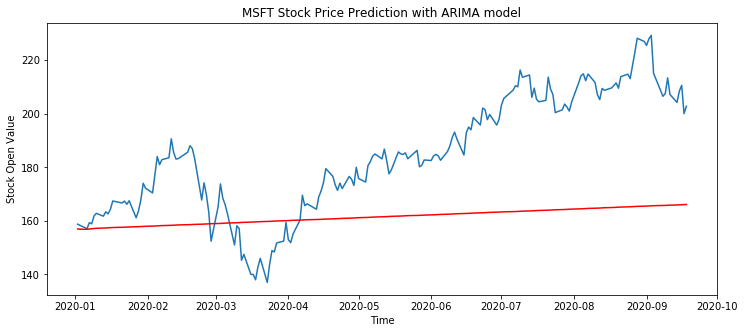

In [36]:
model_arima_full_m=ARIMA(train_m, order=(4,1,1))
model_arima_full_m_fit=model_arima_full_m.fit()
#predictions_arima_full=model_arima_full_fit.forecast(steps=181)[0]
predictions_arima_full_m=pd.Series(model_arima_full_m_fit.forecast(steps=181)[0], index=test_m.index)
plt.figure(figsize=(12,5))
plt.plot(test_m)
plt.plot(predictions_arima_full_m, color='red')
plt.title('MSFT Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

In [38]:
for param in pdq:
    try:
        model_arima=ARIMA(train_m, order=param)
        model_arima_fit=model_arima.fit()
        predictions_arima=model_arima_fit.forecast(steps=181)[0]
        mse=mean_squared_error(test, predictions_arima)
        print(param,model_arima_fit.aic,mse)
    except:
        continue

(0, 0, 0) 25556.808629293497 1248.7013465867217
(0, 0, 1) 22087.005047212195 1253.3328820771105
(0, 0, 2) 19048.437316915253 1262.15793880229
(0, 0, 4) 15045.240862357992 1278.6609973184422
(0, 0, 5) 13827.241902953665 1284.0359533797916
(0, 0, 6) 12673.585257903078 1288.6050444191585
(0, 0, 7) 11975.481099964662 1292.7889825070724
(0, 0, 8) 11305.376348546697 1293.4801286657416
(0, 0, 9) 10855.386824495974 1308.8238066890524
(0, 1, 0) 6694.175622146671 5991.70029823401
(0, 1, 1) 6663.361008966224 6032.274102315856
(0, 1, 2) 6665.35341015594 6031.636994811582
(0, 1, 3) 6666.7352907410705 6033.870155504547
(0, 1, 4) 6658.131512969627 6039.998278587206
(0, 1, 5) 6655.212604168515 6042.23379034322
(0, 1, 6) 6657.2125883670205 6042.217210338756
(0, 1, 7) 6655.470523466947 6018.610339447241
(0, 1, 8) 6657.469980611611 6018.833935420425
(0, 1, 9) 6646.621884147519 5988.966361253547
(0, 2, 0) 8756.127194657924 37040.520476128215
(0, 2, 1) 6694.952189513628 7159.483087065233
(0, 2, 2) 6662.114

Text(0, 0.5, 'Stock Open Value')

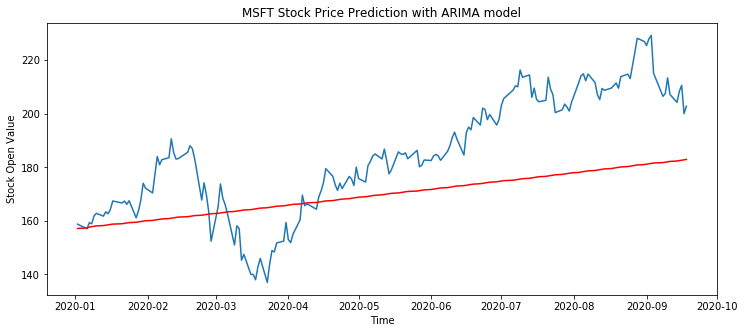

In [37]:
model_arima_full_m=ARIMA(train_m, order=(6,2,2))
model_arima_full_m_fit=model_arima_full_m.fit()
#predictions_arima_full=model_arima_full_fit.forecast(steps=181)[0]
predictions_arima_full_m=pd.Series(model_arima_full_m_fit.forecast(steps=181)[0], index=test_m.index)
plt.figure(figsize=(12,5))
plt.plot(test_m)
plt.plot(predictions_arima_full_m, color='red')
plt.title('MSFT Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

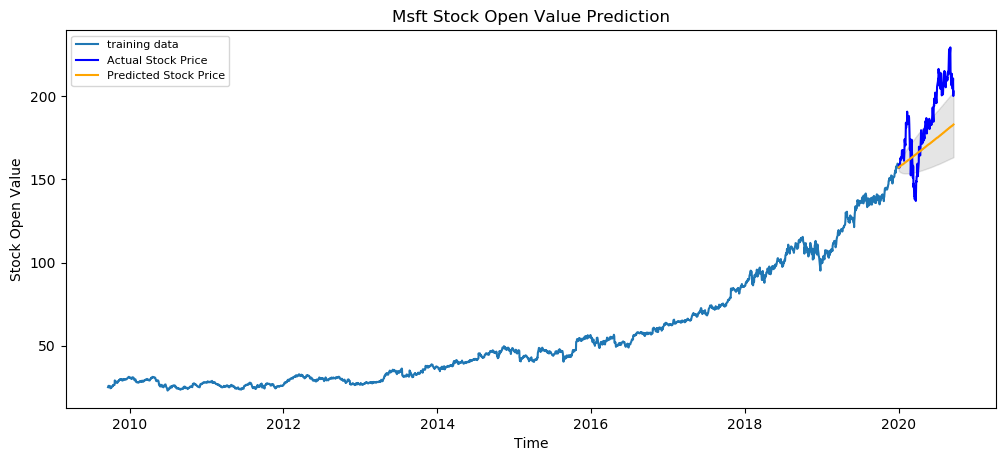

In [39]:
fc_m, se_m, conf_m = model_arima_full_m_fit.forecast(181, alpha=0.05)
fc_series_m = pd.Series(fc_m, index=test_m.index)
lower_series_m = pd.Series(conf_m[:, 0], index=test_m.index)
upper_series_m = pd.Series(conf_m[:, 1], index=test_m.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_m, label='training data')
plt.plot(test_m, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series_m, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series_m.index, lower_series_m, upper_series_m, 
                 color='k', alpha=.10)
plt.title('Msft Stock Open Value Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

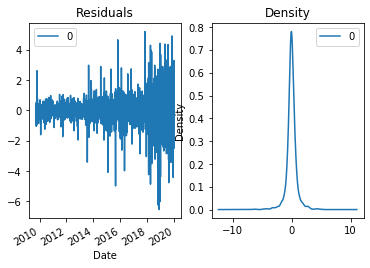

In [130]:
residuals_m = pd.DataFrame(model_arima_full_m_fit.resid)
#figsize=(10,6)
fig, ax = plt.subplots(1,2)
residuals_m.plot(title="Residuals", ax=ax[0])
residuals_m.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [45]:
msft_open_2=msft_open[msft_open.index>='2020-07-01']

In [46]:
msft_open_2.head()

,Open
Date,
2020-07-01,203.139999
2020-07-02,205.679993
2020-07-06,208.830002
2020-07-07,210.449997
2020-07-08,210.070007


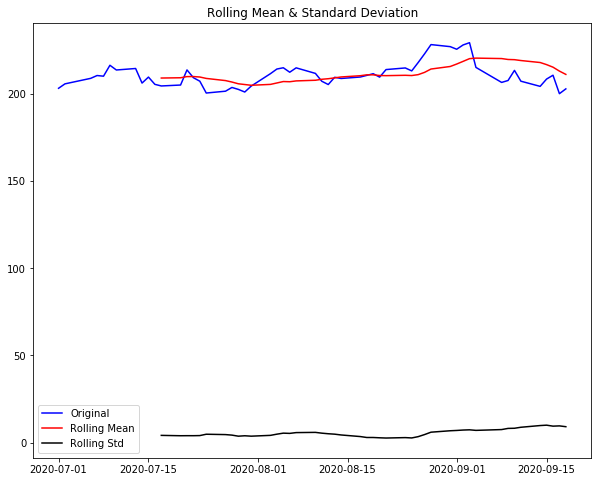

Results of Dickey-Fuller Test:
Test Statistic                 -1.987332
p-value                         0.292155
#Lags Used                      5.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


In [47]:
test_stationarity(msft_open_2)

In [50]:
msft_open_2_dif=msft_open_2.diff(periods=1)
msft_open_2_dif=msft_open_2_dif[1:]

In [51]:
msft_open_2_dif.head()

,Open
Date,
2020-07-02,2.539994
2020-07-06,3.150009
2020-07-07,1.619995
2020-07-08,-0.379990
2020-07-09,6.259995


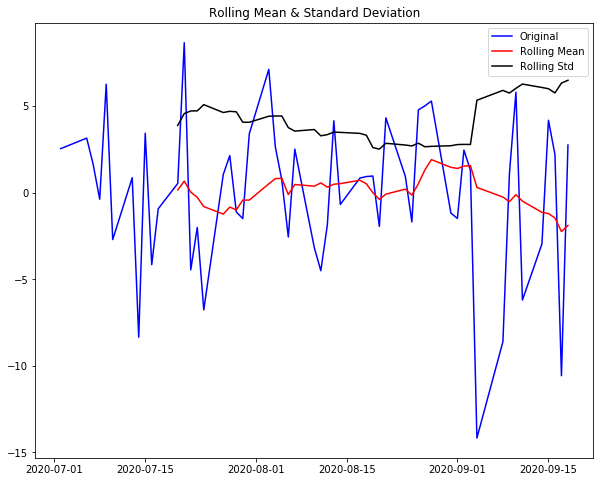

Results of Dickey-Fuller Test:
Test Statistic                 -3.115479
p-value                         0.025429
#Lags Used                     11.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [52]:
test_stationarity(msft_open_2_dif)

In [99]:
train_arima_m=msft_open_2[msft_open_2.index<'2020-09-01'].Open
test_arima_m=msft_open_2[msft_open_2.index>'2020-08-31'].Open

In [100]:
model_ARIMA_m=auto_arima(train_arima_m, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=10, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=False
                      )
print(model_ARIMA_m.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=230.997, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=232.944, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=234.843, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=232.316, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=233.736, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=232.931, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=232.937, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=232.522, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=231.626, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=230.536, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=232.509, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=234.720, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=233.336, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=229.682, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=231.403, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] i

Text(0, 0.5, 'Stock Open Value')

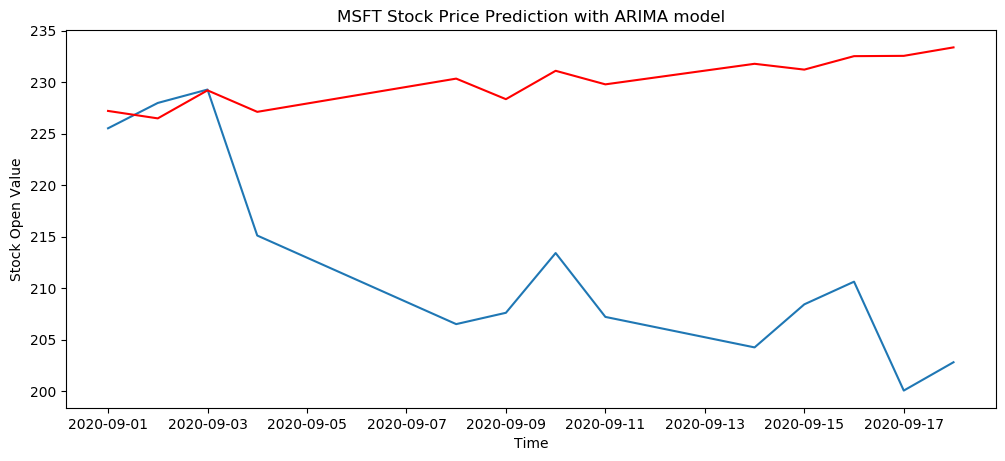

In [102]:
model_arima_m=ARIMA(train_arima_m, order=(2,1,2))
model_arima_m_fit=model_arima_m.fit()
predictions_arima_m=pd.Series(model_arima_m_fit.forecast(steps=13)[0], index=test_arima.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_arima_m)
plt.plot(predictions_arima_m, color='red')
plt.title('MSFT Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

In [33]:
import warnings
warnings.filterwarnings('ignore')

for param in pdq:
    try:
        model_arima=ARIMA(train_arima_m, order=param)
        model_arima_fit=model_arima.fit()
        predictions_arima=model_arima_fit.forecast(steps=13)[0]
        mse=mean_squared_error(test_arima_m, predictions_arima)
        print(param,model_arima_fit.aic,mse)
    except:
        continue

(0, 0, 0) 282.29753671363096 89.69765358036048
(0, 0, 1) 261.14339633189877 79.33108142560165
(0, 0, 2) 242.01082160607842 64.75237741820031
(0, 0, 3) 242.6810627205312 60.64501077321687
(0, 0, 4) 239.24126189857367 40.6789040072418
(0, 0, 5) 240.7192375882936 35.20893600019646
(0, 0, 6) 237.2941028280204 32.89157053126315
(0, 0, 7) 236.37282977078542 32.73123932801107
(0, 0, 8) 238.21003817676007 32.38867653487886
(0, 0, 9) 240.20933959406773 32.41213891190439
(0, 1, 0) 230.99737236805169 475.95891240687104
(0, 1, 1) 232.94382260163613 477.83604803635507
(0, 1, 2) 234.842941768941 484.0755793817502
(0, 1, 3) 232.31554989198412 308.95116759615985
(0, 1, 4) 233.73631794707626 471.347662153514
(0, 1, 5) 232.9384222857842 126.336056467665
(0, 1, 6) 234.39848685425693 145.60326746095976
(0, 1, 7) 231.6763028804952 144.0537765613754
(0, 1, 8) 231.22032396024537 114.58457500599754
(0, 1, 9) 233.0760522325499 121.60582828836543
(0, 2, 0) 256.26809371988753 41.72834472479746
(0, 2, 1) 231.8175

(8, 2, 9) 247.08084672191245 682.2557517885834
(9, 0, 0) 244.27132772681335 56.984946408471224
(9, 0, 1) 297.2694209779991 198.90346767826915
(9, 1, 0) 236.29850619911238 400.66831446357935
(9, 1, 1) 237.25823182205838 302.72133860302705
(9, 1, 2) 240.17478300997107 273.81095308723167
(9, 1, 3) 240.2778104939723 190.26361299847437
(9, 1, 4) 239.69513222582594 389.89570118537824
(9, 1, 8) 244.34117718358226 205.27047863066315
(9, 1, 9) 245.6091908991097 166.413720633006
(9, 2, 0) 236.76110653878266 1359.0708492186407
(9, 2, 2) 237.50427938476778 674.2229147793471
(9, 2, 3) 239.99850990033065 706.6911166953013
(9, 2, 8) 332.24254177366214 1642.9270004649936
(9, 2, 9) 290.38880448244265 602.1357978874964


Text(0, 0.5, 'Stock Open Value')

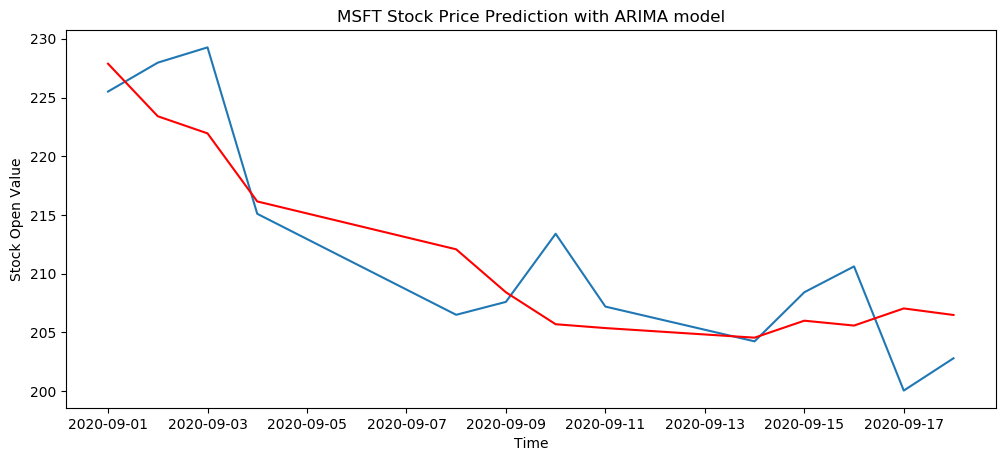

In [104]:
model_arima_m=ARIMA(train_arima_m, order=(6,0,8))
model_arima_m_fit=model_arima_m.fit()
predictions_arima_m=pd.Series(model_arima_m_fit.forecast(steps=13)[0], index=test_arima.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_arima_m)
plt.plot(predictions_arima_m, color='red')
plt.title('MSFT Stock Price Prediction with ARIMA model')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')

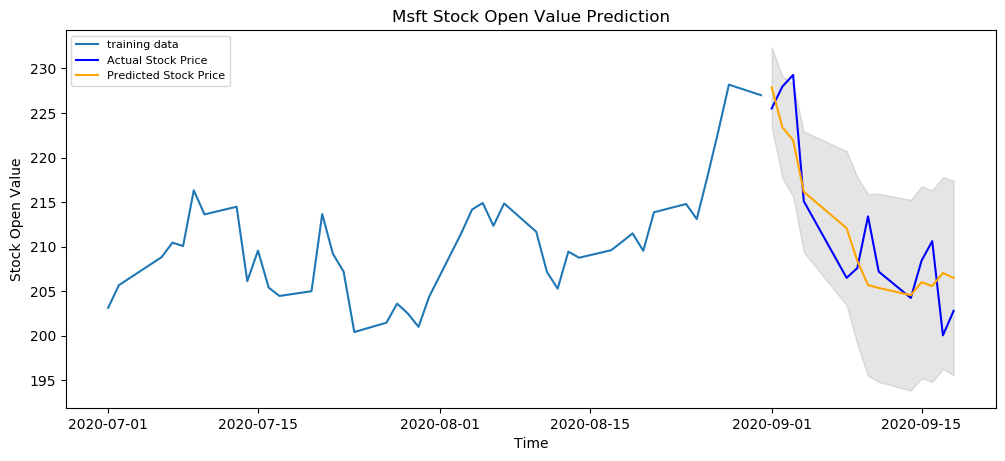

In [106]:
fc_m, se_m, conf_m = model_arima_m_fit.forecast(13, alpha=0.05)
fc_series_m = pd.Series(fc_m, index=test_arima_m.index)
lower_series_m = pd.Series(conf_m[:, 0], index=test_arima_m.index)
upper_series_m = pd.Series(conf_m[:, 1], index=test_arima_m.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_arima_m, label='training data')
plt.plot(test_arima_m, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series_m, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series_m.index, lower_series_m, upper_series_m, 
                 color='k', alpha=.10)
plt.title('Msft Stock Open Value Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Open Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

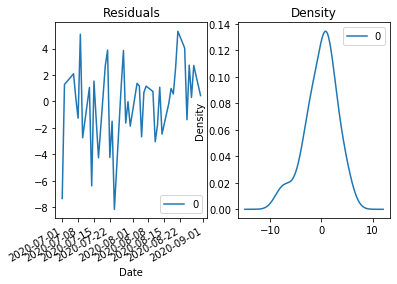

In [110]:
residuals_m = pd.DataFrame(model_arima_m_fit.resid)
#figsize=(10,6)
fig, ax = plt.subplots(1,2)
residuals_m.plot(title="Residuals", ax=ax[0])
residuals_m.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [119]:
predictions_arima_full_m['Date'=='2020-02-14']

157.16733527213827

In [120]:
predictions_arima_full['Date'=='2020-02-14']

72.56646550449719

In [124]:
mean_absolute_error(test,predictions_arima_full) #aapl_full

10.322545767640888

In [125]:
mean_absolute_error(test_arima,predictions_arima) #aapl_july

4.991396803574603

In [126]:
mean_absolute_error(test_m,predictions_arima_full_m) #msft_full

18.495575320676146

In [127]:
mean_absolute_error(test_arima_m,predictions_arima_m) #msft_july

3.8215039091661036